In [1]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
from extract import CategorizeUsers
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import networkx as nx
from numpy import nan

# 1) Download DF

In [22]:
m1 = SocialETL(query="(#slavaukraini OR #stopwarinukraine OR #istandwithputin) is:retweet", pages=500, recent=False) 

Reading secret from C:\Users\david\Documents\GitHub\ds-network-analysis\data\my_secrets.yaml…

Output()

In [23]:
m1.df=m1.df.dropna(subset=['entities.hashtags'])
m1.df=m1.df.dropna(subset=['retweeted_user_id'])

In [24]:
m1.df['entities.hashtags']=m1.df['entities.hashtags'].apply(eval)
m1.df['entities.hashtags']=m1.df['entities.hashtags'].map(h.extract_tags)

In [25]:
df_nodes=pd.DataFrame({"user_id":m1.df['author_id'],
                       'tweet_id':m1.df['id'],
                      'retweet_id': m1.df['retweeted_user_id'],
                      "hashtag":m1.df['entities.hashtags'],
                     'location':m1.df['author.location'],
                     'verified':m1.df['author.verified']
                      })

In [26]:
#df_proukr.set_index('user_id',inplace=True)
df_nodes.shape

(44812, 6)

In [27]:
df_nodes.to_csv('df_nodes')

## preprocessing 

In [2]:
df_nodes=pd.read_csv('df_nodes.csv')
del df_nodes['Unnamed: 0']

In [3]:
df_nodes=df_nodes.set_index('user_id') #,inplace=True)

In [4]:
df_nodes

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"['putin', 'slavaukraini']","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"['stopputin', 'stopwar', 'stopwarinukraine']",NaN,False
1245946724994158592,1503521066739589120,3312966191,"['standwithukraine', 'stopputinnow', 'slavaukr...",NaN,False
854862661,1503521023450361861,465973,['slavaukraini'],NaN,False
42746752,1503520988297932802,1456400208431091712,"['dogsoftwittter', 'dogsoftwitter', 'stoprussi...","Northeast Ohio, USA",False
...,...,...,...,...,...
396145409,1501662088846061577,191393940,"['slavaukraini', 'standwithukraine']","West Midlands, England",False
1486393266782314498,1501662072094048266,279390084,"['fckptn', 'slavaukraini']",NaN,False
1390353643,1501662038195638272,1192160073897988096,"['standwithukraine', 'istandwithukraine', 'sla...",County Cork,False


In [5]:
df_nodes.index=df_nodes.index.map(int)
df_nodes['hashtag']=df_nodes['hashtag'].map(str).apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(str).apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(str).apply(eval)
df_nodes['location']=df_nodes['location'].map(str)#.apply(eval)
df_nodes['verified']=df_nodes['verified'].map(str).apply(eval)

In [6]:
df_nodes.shape

(47853, 5)

In [7]:
df_nodes.head(3)

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"[putin, slavaukraini]","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"[stopputin, stopwar, stopwarinukraine]",nan,False
1245946724994158592,1503521066739589120,3312966191,"[standwithukraine, stopputinnow, slavaukraini]",nan,False


In [8]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)

In [9]:
df_nodes.head(3)

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"{slavaukraini, putin}","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"{stopputin, stopwar, stopwarinukraine}",nan,False
1245946724994158592,1503521066739589120,3312966191,"{standwithukraine, stopputinnow, slavaukraini}",nan,False


In [10]:
df_nodes.loc[df_nodes['location']=='nan']

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1464582321533767695,1503521249850363904,291496884,"{stopputin, stopwar, stopwarinukraine}",nan,False
1245946724994158592,1503521066739589120,3312966191,"{standwithukraine, stopputinnow, slavaukraini}",nan,False
854862661,1503521023450361861,465973,{slavaukraini},nan,False
1298987457908633602,1503520942147969038,81599450,"{slavaukraini, johnsonout49}",nan,False
1265688143698685952,1503520921038245888,1437315069000314888,"{taipei, slavaukraini, ukraine}",nan,False
...,...,...,...,...,...
1438502419801903108,1501662278235602951,1496810215680978954,"{russiaukraine, kyiv, russianukrainianwar, bre...",nan,False
1325145636153356290,1501662276977311750,191393940,"{standwithukraine, slavaukraini}",nan,False
4033666373,1501662191811977221,1205226529455632385,{slavaukraini},nan,False


# 2) Categorizzazione utenti

In [11]:
set_user=set(df_nodes.index)
print(len(set_user))

32382


In [ ]:
cat = CategorizeUsers(set_user, pages=1) #max_results=100 from 15-2 to 15-3

In [12]:
with open('categorize.json', 'r') as f:
    cat = json.load(f)
cat

{'1126026130203582464': 'proukr',
 '1301204310206840833': 'proukr',
 '1276426094242127874': 'proukr',
 '914089454511439875': 'proukr',
 '892318583748820994': 'proukr',
 '1233535933154197508': 'proukr',
 '1321173403429150726': 'proukr',
 '1265033587335757828': 'proukr',
 '1497612213766471688': 'proukr',
 '1410177732483317769': 'proukr',
 '1496871443505815561': 'proukr',
 '1357708828083683331': 'proukr',
 '1243995914341056517': 'proukr',
 '1316629728296566789': 'proukr',
 '1374989164664520711': 'proukr',
 '1473401352567070726': 'proukr',
 '1384173653743443975': 'proukr',
 '1444306356073340936': 'proukr',
 '1497189220443693066': 'proukr',
 '1437164333931372557': 'proukr',
 '42991636': 'proukr',
 '1472639914059702289': 'proukr',
 '54566935': 'proukr',
 '1497132750205247512': 'proukr',
 '288718876': 'proukr',
 '295231519': 'proukr',
 '1496946156487819297': 'proukr',
 '1310289087702630447': 'proukr',
 '515006515': 'proukr',
 '3338772538': 'proukr',
 '1286905933': 'proukr',
 '15794264': 'prou

In [13]:
c_proukr = 0
c_pax = 0
c_nocare = 0
c_prorus= 0

for v in cat.values():
    if v == "proukr":
        c_proukr += 1 
    elif v == "pax":
        c_pax += 1
    elif v == "prorus":
        c_prorus += 1
    else:
        c_nocare += 1

print('TOT USERS = {} \n'
      'proukr = {} \n'
      'pax = {} \n'
      'prorus = {} \n'
      'nocare = {} \n'.format(len(cat),c_proukr,c_pax, c_prorus, c_nocare))

TOT USERS = 32382 
proukr = 21987 
pax = 6921 
prorus = 1266 
nocare = 2208 



In [14]:
user_node=[]
user_cat=[]
for k,v in cat.items():
    user_node.append(k)
    user_cat.append(v)

In [15]:
df_cat=pd.DataFrame({'user_id':user_node,
                     'cat': user_cat})
df_cat=df_cat.set_index('user_id')
df_cat.index=df_cat.index.map(int)

In [16]:
df_cat

,cat
user_id,
1126026130203582464,proukr
1301204310206840833,proukr
1276426094242127874,proukr
914089454511439875,proukr
892318583748820994,proukr
...,...
14106605,proukr
2243559410,proukr
978460662,proukr


In [17]:
#copy of the dataset with distinct index
#copy because duplicates need to accounted to assign weights
df_nodes_copy = df_nodes[~df_nodes.index.duplicated(keep='first')]
df_nodes_copy

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"{slavaukraini, putin}","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"{stopputin, stopwar, stopwarinukraine}",nan,False
1245946724994158592,1503521066739589120,3312966191,"{standwithukraine, stopputinnow, slavaukraini}",nan,False
854862661,1503521023450361861,465973,{slavaukraini},nan,False
42746752,1503520988297932802,1456400208431091712,"{dogsoftwittter, pup, stoprussia, war, stopput...","Northeast Ohio, USA",False
...,...,...,...,...,...
396145409,1501662088846061577,191393940,"{standwithukraine, slavaukraini}","West Midlands, England",False
1486393266782314498,1501662072094048266,279390084,"{fckptn, slavaukraini}",nan,False
1390353643,1501662038195638272,1192160073897988096,"{standwithukraine, istandwithukraine, slavaukr...",County Cork,False


In [18]:
df_final=pd.concat(objs=[df_nodes_copy,df_cat], axis=1)

In [19]:
df_final

,tweet_id,retweet_id,hashtag,location,verified,cat
user_id,,,,,,
290883,1502663077191426051,2956836471,"{johnsonout47, nhsbadbill, slavaukraini}",European Union,False,pax
298073,1503178785746685954,889765401822973952,{slavaukraini},nan,False,proukr
611093,1501988978345627654,56698771,"{ukraine, standwithukraine, odesa, slavaukrain...",istanbul,False,pax
699793,1502982769219371008,154830217,"{slavaukraini, ukrainerussiawar}",Pale Blue Dot/127.0.0.1,False,pax
756049,1502704662138568705,1255561430,"{slavaukraini, ukraine}",France,False,proukr
...,...,...,...,...,...,...
1503222685484081154,1503248107512942593,1447150441481965568,"{istandwithputin, supportrussia, standwithruss...",nan,False,proukr
1503274603770171392,1503280632209756160,1390437709286715403,"{istandwithputin, putler}",nan,False,proukr
1503322318461968385,1503421219877568515,1455570393368956936,"{standwithputin, istandwithputin, standwithrus...",Occupied America,False,proukr


In [20]:
df_final.to_csv('df_final')

# 3 Creazione rete

In [21]:
G = nx.Graph()

In [22]:
for i,e in df_final.iterrows():
    G.add_node(i, category=df_final['cat'][i]) #, location=df_final['location'][i] verified=df_final['verified'][i],

In [23]:
list(G.nodes.data())

[(290883, {'category': 'pax'}),
 (298073, {'category': 'proukr'}),
 (611093, {'category': 'pax'}),
 (699793, {'category': 'pax'}),
 (756049, {'category': 'proukr'}),
 (800485, {'category': 'pax'}),
 (810603, {'category': 'dontcare'}),
 (916201, {'category': 'pax'}),
 (917131, {'category': 'proukr'}),
 (1050111, {'category': 'proukr'}),
 (1054431, {'category': 'proukr'}),
 (1080161, {'category': 'dontcare'}),
 (1111871, {'category': 'proukr'}),
 (1471971, {'category': 'proukr'}),
 (1524781, {'category': 'pax'}),
 (1630511, {'category': 'proukr'}),
 (1772721, {'category': 'proukr'}),
 (2002721, {'category': 'proukr'}),
 (2052911, {'category': 'pax'}),
 (2364531, {'category': 'pax'}),
 (2462851, {'category': 'proukr'}),
 (2827221, {'category': 'dontcare'}),
 (3306811, {'category': 'proukr'}),
 (3554911, {'category': 'proukr'}),
 (3632161, {'category': 'pax'}),
 (3688111, {'category': 'proukr'}),
 (3796501, {'category': 'proukr'}),
 (3799971, {'category': 'proukr'}),
 (4254951, {'category'

In [37]:
#PRIMA DATASET-->POI DIZIONARIO--->POI COLLEGARE LINK CON NODI + PESI
from_u=[]
to_u=[]
for u, user in enumerate(df_nodes.index):
    #print('u',user, type(user))
    for r,ret in enumerate(df_nodes['retweet_id']):
        #print('ret',ret, type(ret))
        if user==ret and user!=df_nodes.index[r]:
                from_u.append(user)
                to_u.append(df_nodes.index[r])

In [38]:
df=pd.DataFrame({'from':from_u,
                'to':to_u})
df.shape

(198199, 2)

In [39]:
df_weighted = df.value_counts().to_frame("weights").reset_index()
df_weighted.head(3)

,from,to,weights
0,2202063265,1081484761934319623,2496
1,1380145054644379652,1402929890442285056,1681
2,820731335157383170,615660889,1274


In [40]:
df_weighted["weights"] = (df_weighted["weights"] - (df_weighted["weights"]).min())/((df_weighted["weights"].max()-(df_weighted["weights"]).min()))
df_weighted.head(3)

,from,to,weights
0,2202063265,1081484761934319623,1.000000
1,1380145054644379652,1402929890442285056,0.673347
2,820731335157383170,615660889,0.510220


In [41]:
df_weighted.shape

(11663, 3)

In [22]:
df_weighted.to_csv('df_weighted')

In [24]:
df_weighted=pd.read_csv('df_weighted')
del df_weighted['Unnamed: 0']

In [37]:
for i,e in df_weighted.iterrows():
    print(df_weighted['weights'][i])
    G.add_edge(df_weighted['from'][i],df_weighted['to'][i], weight=df_weighted['weights'][i] )

1.0
0.5683430045132173
0.5451321727917473
0.4951644100580271
0.4845261121856866
0.4577691811734365
0.423920051579626
0.412314635718891
0.3633139909735654
0.3549323017408123
0.3175370728562218
0.2894906511927788
0.2894906511927788
0.2762733720180528
0.2520954223081882
0.2520954223081882
0.2421018697614442
0.2240490006447453
0.2240490006447453
0.2117988394584139
0.2117988394584139
0.2117988394584139
0.1960025789813023
0.1853642811089619
0.1814958091553836
0.1814958091553836
0.1679561573178594
0.1679561573178594
0.1586073500967117
0.1586073500967117
0.1544165054803352
0.1511927788523533
0.1511927788523533
0.1511927788523533
0.1492585428755641
0.1492585428755641
0.1399097356544165
0.1389426176660219
0.1350741457124435
0.1305609284332688
0.1305609284332688
0.1254029658284977
0.120889748549323
0.120889748549323
0.120889748549323
0.120889748549323
0.1170212765957446
0.1157317859445519
0.1157317859445519
0.1157317859445519
0.1131528046421663
0.1128304319793681
0.1118633139909735
0.102836879432

0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590586718
0.0228884590

0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0090264345583494
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618955512
0.0087040618

0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086395873
0.0022566086

0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359767891
0.0019342359

0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179883945
0.0009671179

0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726627981
0.0003223726

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [26]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))

In [27]:
list(G.edges.data())

[(290883, 2956836471, {'weight': 0.0228884590586718}),
 (1054431, 976028069168402433, {'weight': 0.0}),
 (1471971, 1205226529455632385, {'weight': 0.0}),
 (2052911, 1401015246718914560, {'weight': 0.0667311411992263}),
 (2052911, 2202063265, {'weight': 0.04642166344294}),
 (2052911, 1317817827970134025, {'weight': 0.0177304964539007}),
 (2052911, 1353366187791560704, {'weight': 0.0109606705351386}),
 (2052911, 316797199, {'weight': 0.0096711798839458}),
 (2827221, 4018888580, {'weight': 0.0}),
 (3688111, 1499295169870319616, {'weight': 0.0}),
 (4254951, 282076470, {'weight': 0.0003223726627981}),
 (4615341, 27493883, {'weight': 0.0019342359767891}),
 (4937571, 4018888580, {'weight': 0.0}),
 (5404582, 2322424306, {'weight': 0.0003223726627981}),
 (5516892, 4018888580, {'weight': 0.0}),
 (5749002, 2301844336, {'weight': 0.0}),
 (5849252, 1142623492141211650, {'weight': 0.0003223726627981}),
 (6266142, 1081484761934319623, {'weight': 0.0512572533849129}),
 (6266142, 2956836471, {'weight':

number of nodes = 11197 , number of edges = 12767 . number of components = 225


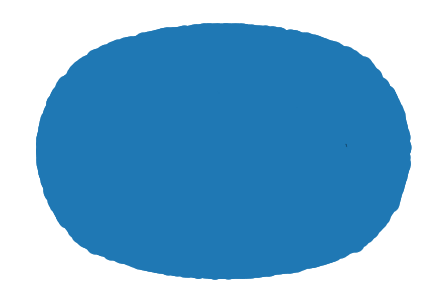

In [28]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [72]:
nx.write_gexf(G,'first_net.gexf')
#nx.write_gexf(G,'net_50')

In [2]:
G=nx.read_gexf('first_net.gexf')

In [3]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[10184,
 37,
 33,
 28,
 26,
 21,
 19,
 18,
 18,
 16,
 16,
 14,
 14,
 14,
 13,
 13,
 12,
 12,
 11,
 10,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [4]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(S))

225


In [5]:
for e in S:
    print(e)

Graph with 10184 nodes and 11968 edges
Graph with 2 nodes and 1 edges
Graph with 3 nodes and 2 edges
Graph with 5 nodes and 4 edges
Graph with 37 nodes and 40 edges
Graph with 3 nodes and 2 edges
Graph with 4 nodes and 3 edges
Graph with 6 nodes and 5 edges
Graph with 3 nodes and 2 edges
Graph with 3 nodes and 2 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 18 nodes and 20 edges
Graph with 7 nodes and 6 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 14 nodes and 13 edges
Graph with 11 nodes and 10 edges
Graph with 14 nodes and 13 edges
Graph with 6 nodes and 5 edges
Graph with 28 nodes and 27 edges
Graph with 6 nodes and 5 edges
Graph with 6 nodes and 5 edges
Graph with 26 nodes and 25 edges
Graph with 3 nodes and 2 edges
Graph with 3 nodes and 2 edges
Graph with 16 nodes and 15 edges
Graph with 2 nodes and 1 edges
Graph with 3 nodes and 2 edges
Graph with 6 nodes and 5 edges
Graph with 3 nodes and 2 edges
Graph with 5 no

In [74]:
for i,e in enumerate(S):
    print('component',i)
    print(list(e.nodes.data()))

component 0
[(290883, {'category': 'pax', 'verified': False, 'location': 'European Union'}), (1471971, {'category': 'proukr', 'verified': False, 'location': 'nan'}), (2052911, {'category': 'pax', 'verified': False, 'location': 'London, England'}), (2827221, {'category': 'dontcare', 'verified': False, 'location': 'NYC'}), (3688111, {'category': 'proukr', 'verified': False, 'location': 'Bangkok'}), (4254951, {'category': 'proukr', 'verified': False, 'location': 'Berkeley CA'}), (4615341, {'category': 'proukr', 'verified': False, 'location': 'Paris of the Piedmont'}), (4937571, {'category': 'pax', 'verified': False, 'location': 'Moss Beach, CA'}), (5404582, {'category': 'pax', 'verified': False, 'location': 'Lugano'}), (5516892, {'category': 'proukr', 'verified': False, 'location': 'Chicago, IL'}), (5749002, {'category': 'proukr', 'verified': False, 'location': "Martha's Vineyard, USA"}), (5849252, {'category': 'proukr', 'verified': False, 'location': 'Ocean City, Maryland'}), (6266142, {

In [29]:
#remove small components
c=0
th=40
for component in list(nx.connected_components(G)):
    c += 1
    if len(component)<th:
        for node in component:
            G.remove_node(node)

number of nodes = 10184 , number of edges = 11968 . number of components = 1


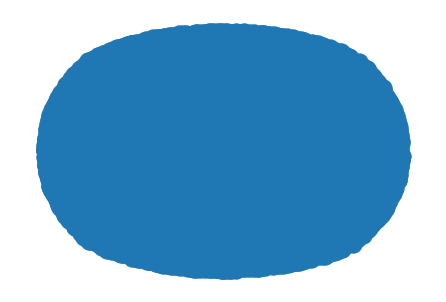

In [30]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [31]:
nx.write_gexf(G,'final_net.gexf')

In [32]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(S))

1


In [33]:
for e in S:
    print(e)

Graph with 10184 nodes and 11968 edges


In [34]:
for i,e in enumerate(S):
    print('component',i)
    print(list(e.nodes.data()))

component 0
[(290883, {'category': 'pax'}), (1471971, {'category': 'proukr'}), (2052911, {'category': 'pax'}), (2827221, {'category': 'dontcare'}), (3688111, {'category': 'proukr'}), (4254951, {'category': 'proukr'}), (4615341, {'category': 'proukr'}), (4937571, {'category': 'pax'}), (5404582, {'category': 'pax'}), (5516892, {'category': 'proukr'}), (5749002, {'category': 'proukr'}), (5849252, {'category': 'proukr'}), (6266142, {'category': 'proukr'}), (6691762, {'category': 'proukr'}), (7078452, {'category': 'proukr'}), (7703052, {'category': 'proukr'}), (7777302, {'category': 'proukr'}), (8007502, {'category': 'proukr'}), (8052182, {'category': 'proukr'}), (9063952, {'category': 'proukr'}), (9147152, {'category': 'proukr'}), (9731332, {'category': 'dontcare'}), (11025592, {'category': 'proukr'}), (11076222, {'category': 'dontcare'}), (11486222, {'category': 'dontcare'}), (11567702, {'category': 'pax'}), (12512292, {'category': 'proukr'}), (12610772, {'category': 'pax'}), (13301942, {

In [35]:
print(G.edges.data())

[(290883, 2956836471, {'weight': 0.0228884590586718}), (1471971, 1205226529455632385, {'weight': 0.0}), (2052911, 1401015246718914560, {'weight': 0.0667311411992263}), (2052911, 2202063265, {'weight': 0.04642166344294}), (2052911, 1317817827970134025, {'weight': 0.0177304964539007}), (2052911, 1353366187791560704, {'weight': 0.0109606705351386}), (2052911, 316797199, {'weight': 0.0096711798839458}), (2827221, 4018888580, {'weight': 0.0}), (3688111, 1499295169870319616, {'weight': 0.0}), (4254951, 282076470, {'weight': 0.0003223726627981}), (4615341, 27493883, {'weight': 0.0019342359767891}), (4937571, 4018888580, {'weight': 0.0}), (5404582, 2322424306, {'weight': 0.0003223726627981}), (5516892, 4018888580, {'weight': 0.0}), (5749002, 2301844336, {'weight': 0.0}), (5849252, 1142623492141211650, {'weight': 0.0003223726627981}), (6266142, 1081484761934319623, {'weight': 0.0512572533849129}), (6266142, 2956836471, {'weight': 0.0228884590586718}), (6691762, 1247652514478112773, {'weight': 0

In [36]:
c_proukr = 0
c_pax = 0
c_nocare = 0
c_prorus= 0

for i,e in enumerate(S):
    for node in e.nodes.data():
        for idx,attribute in node[1].items():
            if attribute == "proukr":
                c_proukr += 1 
            elif attribute == "pax":
                c_pax += 1
            elif attribute == "prorus":
                c_prorus += 1
            elif attribute == "dontcare":
                c_nocare += 1

print('TOT USERS = {} \n'
      'proukr = {} \n'
      'pax = {} \n'
      'prorus = {} \n'
      'nocare = {} \n'.format(len(G.nodes),c_proukr,c_pax, c_prorus, c_nocare))
            

TOT USERS = 10184 
proukr = 6922 
pax = 2165 
prorus = 416 
nocare = 681 



In [66]:
def make_node_df(G):
    nodes = {}
    for node, attribute in G.nodes(data=True):
        if not nodes.get('node'):
            nodes['node'] = [node]
        else:
            nodes['node'].append(node)

        for key, value in attribute.items():
            if not nodes.get(key):
                nodes[key] = [value]
            else:
                nodes[key].append(value)

    return pd.DataFrame(nodes)

def make_edge_df(G):
    edges = {}
    for source, target, attribute in G.edges(data=True):

        if not edges.get('source'):
            edges['source'] = [source]
        else:
            edges['source'].append(source)

        if not edges.get('target'):
            edges['target'] = [target]
        else:
            edges['target'].append(target)

        for key, value in attribute.items():
            if not edges.get(key):
                edges[key] = [value]
            else:
                edges[key].append(value)
    return pd.DataFrame(edges)

In [72]:
df_final_nodes=make_node_df(G)
df_final_nodes.to_csv('df_final_nodes')

In [73]:
df_final_edges=make_edge_df(G)
df_final_edges.to_csv('df_final_edges')